 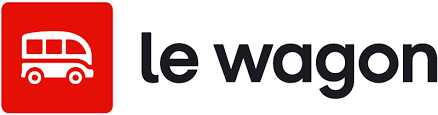

# Predict Greenweez Churners


We want to find who amongst our existing database of clients will reconvert 🔁 (ie. make a second purchase) within 3 months.

➡️ We have access to the sales from 2019 to 2021.
➡️ Let's take a look at the data


## Data discovery


a) Execute cell below to load data into `df` variable.

In [1]:
import pandas as pd
from google.cloud import bigquery

client = bigquery.Client()

# Query Bigquery
query = '''
SELECT * 
FROM `lewagon1390.course33.gwz_churn`
'''

In [3]:
df = client.query(query).to_dataframe()

In [8]:
df2 = pd.read_gbq(query)


b) Let's take a look at our data.

What do you see? What's the shape of our data? Do you have null values ? What is target ?

In [9]:
df.shape

(381398, 12)

In [10]:
df.head(10)

,date_date,orders_id,customers_id,nb_past_orders,avg_basket,total_purchase_cost,avg_quantity,total_quantity,nb_days_since_last_order,avg_nb_unique_products,total_nb_codes,re_purchase
0,2021-03-08,797405,207754,3,65.456667,196.37,29.333333,88,0,23.000000,1,0
1,2021-06-23,914331,229390,2,84.650000,169.30,40.000000,80,0,34.500000,1,0
2,2021-04-27,857750,4921,3,48.343333,145.03,20.000000,60,0,11.666667,1,1
3,2021-02-28,786589,10797,8,74.970000,599.76,26.500000,212,0,20.750000,8,1
4,2021-06-08,901782,116681,3,62.113333,186.34,16.666667,50,0,9.333333,1,0
5,2020-10-03,601975,168129,4,75.352500,301.41,30.000000,120,0,23.500000,1,1
6,2021-02-21,779864,193476,3,77.710000,233.13,23.000000,69,0,17.333333,1,1
7,2021-01-25,746501,35639,2,107.485000,214.97,33.500000,67,0,20.500000,1,1
8,2021-05-16,879372,109903,3,98.533333,295.60,32.666667,98,0,30.000000,1,1
9,2021-04-25,854402,69443,5,74.856000,374.28,24.800000,124,0,15.600000,5,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381398 entries, 0 to 381397
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   date_date                 381398 non-null  dbdate 
 1   orders_id                 381398 non-null  Int64  
 2   customers_id              381398 non-null  Int64  
 3   nb_past_orders            381398 non-null  Int64  
 4   avg_basket                381398 non-null  float64
 5   total_purchase_cost       381398 non-null  float64
 6   avg_quantity              381398 non-null  float64
 7   total_quantity            381398 non-null  Int64  
 8   nb_days_since_last_order  381398 non-null  Int64  
 9   avg_nb_unique_products    381398 non-null  float64
 10  total_nb_codes            381398 non-null  Int64  
 11  re_purchase               381398 non-null  Int64  
dtypes: Int64(7), dbdate(1), float64(4)
memory usage: 37.5 MB


<details>
    <summary><i>Answer:</i></summary>

Your DataFrame should be of shape 381398 * 12.
    
The target is the `re_purchase` column, and the other columns will be your features.
    
There are no null values in data.
</details>        

c) What do you think of column `orders_id` for our problem? Is it useful?

<details>
    <summary><i>Answer:</i></summary>

Orders_id is not useful here as it is a unique identifier in Greenweez database.
</details>   

d) Delete `orders_id` and `date_date` columns.

In [12]:
df = df.drop(columns = ['date_date', 'orders_id'])

e) Are columns values on different scales? Use DataFrame `.describe()` function to answer.

What kind of preprocessing we will have to use ?

In [13]:
df.describe()

,customers_id,nb_past_orders,avg_basket,total_purchase_cost,avg_quantity,total_quantity,nb_days_since_last_order,avg_nb_unique_products,total_nb_codes,re_purchase
count,381398.0,381398.0,381398.000000,381398.000000,381398.000000,381398.0,381398.0,381398.000000,381398.0,381398.0
mean,161066.560242,2.058692,51.570302,124.525402,13.558555,33.825301,0.0,8.392141,0.544751,0.476864
std,95853.282456,2.030991,41.144718,291.427518,13.202761,71.181359,0.0,7.364444,1.441715,0.499465
min,2.0,1.0,0.000000,0.000000,1.000000,1.0,0.0,1.000000,0.0,0.0
25%,69762.0,1.0,26.290000,30.310000,5.500000,7.0,0.0,3.000000,0.0,0.0
50%,174880.0,1.0,43.760000,65.550000,10.333333,16.0,0.0,6.500000,0.0,0.0
75%,244394.0,2.0,66.840000,150.350000,18.000000,38.0,0.0,11.500000,1.0,1.0
max,314334.0,61.0,4726.440000,22738.110000,1480.000000,3557.0,0.0,163.000000,57.0,1.0


<details>
    <summary><i>Answer:</i></summary>

Features are indeed on different scales, total_nb_codes in comparison with avg_basket for examples.

We will use a normalization technique.
</details>

f) Set column `customers_id` as index to keep customer_id information.

In [14]:
df = df.set_index('customers_id')

In [15]:
df.head(1)

,nb_past_orders,avg_basket,total_purchase_cost,avg_quantity,total_quantity,nb_days_since_last_order,avg_nb_unique_products,total_nb_codes,re_purchase
customers_id,,,,,,,,,
207754,3,65.456667,196.37,29.333333,88,0,23.0,1,0


Note that for the sake of the exercise, we've **already preprocessed some of the data for you** 🔧.

This means you'll be working on a (relatively) clean database, with your targets and features already formed. In a real-world situation, it's likely that you'll be spending a lot of time forming your target and features from simpler, less-specific data, either using python or SQL to manipulate the database.

## Modeling

Now that we've seen what our data looks like, we need to define our target and features.

a) Split dataset into a train and a test set (this should give you an `X_train`, `X_test`, `y_train` and `y_test`).

We will keep a test_size of 20%.

In [21]:
from sklearn.model_selection import train_test_split

# every columns except re_purchase which is our target
X = df.drop(columns='re_purchase')
y = df['re_purchase'].astype("int")

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# store customers_ids for after
test_customers_ids = X_test.index

b) Execute cell below to apply a normalization on data.

We use here a StandardScaler transformation.

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# apply same transformation on X_test
X_test = scaler.transform(X_test)

c) What is the type of X_train and X_test? Is it expected?

In [27]:
print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


c) It's now time to use your first classifier model.

We will use a logistic regression model. Execute cell below to train your model on train data and store test data predictions in a variable `y_pred`.

In [28]:
from sklearn.linear_model import LogisticRegression

# train model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# store predictions
y_pred = clf.predict(X_test)

d) Calculate accuracy you get on train and test data.

How can you interpret it?

In [29]:
accuracy_train = clf.score(X_train, y_train)
accuracy_test = clf.score(X_test, y_test)

print(f"{accuracy_train=}")
print(f"{accuracy_test=}")

accuracy_train=0.7312973996945444
accuracy_test=0.7318169900367069


<details>
    <summary><i>Answer:</i></summary>

Logistic regression score corresponds to accuracy.
We see here 73% accuracy on both train and test data. It means that 73% of our predictions are good.

There is no overfitting as there is no difference in scores between train and test
</details>

e) Accuracy is one way to judge model performance but ploting confusion matrix on test data is a better technique. Because from this matrix you can get plently of metrics !

Execute cell below to plot confusion matrix.

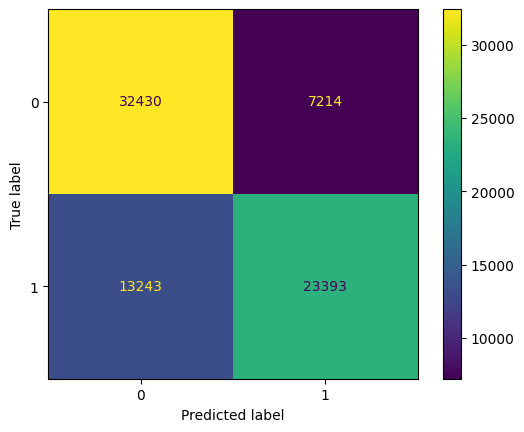

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
confusion_matrix = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

f) From confusion matrix and below picture, calculate:
- precision
- recall
- accuracy

![confusionmetrucs](https://yury-zablotski.netlify.app/post/confusion-matrix/ssw.png)

<details>
    <summary><i>Answer:</i></summary>

- precision: 23142 / (23142 + 7269) = 23142 / 30411 = 75.94%
- recall: 23142 / (13150 + 23142) = 23142 / 36292 = 63.77%
- accuracy: (32719 + 23142) / 76280 = 55861 / 76280 = 73.23%
</details>

g) What is percent of churners your model correctly detected? Is it good?

<details>
    <summary><i>Answer:</i></summary>

number_churners_correctly_detected / number_of_churners = 32719 / (32719 + 7269) = 32504 / 39988 = 81.82%

Not bad at all, we have now a model to identify 81.82% of churners :)
</details>

h) Is it better than a stupid model returning always 1?

Obviously, we will have really bad precision and recall metrics.

i) What does this instruction do? How useful it can be from a business perspective?

In [31]:
proba = pd.DataFrame(clf.predict_proba(X_test), columns=["Churner", "Not churner"], index=test_customers_ids)
proba

,Churner,Not churner
customers_id,,
232408,0.316997,0.683003
9551,0.674053,0.325947
218810,0.789534,0.210466
144700,0.000271,0.999729
28906,0.750480,0.249520
...,...,...
182272,0.275139,0.724861
6244,0.243649,0.756351
267899,0.772271,0.227729


<details>
    <summary><i>Answer:</i></summary>

We can get probability to repurchase or not (column not churner).
</details>

j) Filter on customers who have between 20% and 50% probability to re purchase.

customers with less than 20% of probability to repurchase are considered as lost.

In [32]:
proba[(proba["Not churner"] >= 0.2) & (proba["Not churner"] < 0.5)]

,Churner,Not churner
customers_id,,
9551,0.674053,0.325947
218810,0.789534,0.210466
28906,0.750480,0.249520
301663,0.791465,0.208535
233567,0.540725,0.459275
...,...,...
208112,0.546774,0.453226
160874,0.729236,0.270764
267899,0.772271,0.227729


k) Now you have this model.

Explain which process you suggest to create at greenweez to reduce churn rate?



<details>
    <summary><i>Answer:</i></summary>

On a regular basis, predict churners and send this info back to CRM via ELT process.

CRM team will target those users to send them coupon codes, discounts, ...
to retain them.

This technique is really powerful
</details>